# Seminar class 6: Twitter Streaming API

---

In this exercise, we stream Twitter data (live) and read tweets that involve `Trump`.
The installations and configurations involved are relatively challenging.

## Preliminary

To run this notebook will may need to perform the following steps:

1. Start Kafka
    * start a Kafka server by navigating to `/usr/lib/kafka` and running
    
        `bin/kafka-server-start.sh config/server.properties &`


2. Download the Natural Language Toolkit (see cell below) and copy them to `/usr/share/` directory in the cluster machine
    * install the python module `nltk` (should be installed already, as part of the initialisation actions)
    * download the right `nltk` packages, namely `stopwords` and `punkt` using python shell.
    * `sudo cp -r nltk_data/ /usr/share/nltk_data`: this is `/usr/share` is one of the default paths that `nltk` will search
    
    
3. We will need to manually add the spark streaming  kafka jar, as this i not part of the standard spark distribution (which is a phenomenal pain in the back). The right one is this one: [spark-streaming-kafka-0-8-assembly_2.11-2.3.2.jar](https://mvnrepository.com/artifact/org.apache.spark/spark-streaming-kafka-0-8-assembly_2.11/2.3.2)
    * You can download it into them home directory on your cluster using 
    
    ```
    wget https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.3.2/spark-streaming-kafka-0-8-assembly_2.11-2.3.2.jar
    ```
    
    * Then copy it into the right direcotry using 
    
    ```
    sudo cp spark-streaming-kafka-0-8-assembly_2.11-2.3.2.jar /usr/lib/spark/jars/
    ```
    
    
4. Run the [kafka_twitter_producer.py](kafka_twitter_producer.py) in `~` to get tweets from the twitter API
    * First, install the python modules `kafka-python` and `tweepy` (this should already be completed, as part of the initialisation actions for the cluster that I provided)
    * Upload kafka_twitter_producer.py to your master node (though a bucket) and update it with your own twitter information (for eample using the nano editor). See https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens for more details.
    * You might need to apply for a twitter developer account and create a twitter app to access the required tokens and keys (`https://developer.twitter.com/en/apps/create`)
    * You will need to add your own `consumer_key`, `consumer_secret`, `access_token` and `access_token_secret` generated py twitter to the python file. They all *should* look like gibberish.
    * Have a look at the rest of the python script and make sure that you understand it.
    * Run the kafka_twitter_producer.py with the command: 
    `python kafka_twitter_producer.py`
    * It should print a lot of numbers to stdout. these are the lengths of tweets. Keep it running, as this is what streams tweets as a kafka producer.
    
5. Finally, re-start the kernel of this notebook and run all (using a PySpark kernel)!

## Start Kafka 

In [1]:
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
import json

ssc = StreamingContext(sc, 10)
print(sc)
kafka_stream = KafkaUtils.createStream(ssc, \
                                       "localhost:2181", \
                                       "test-consumer-group", \
                                        {"twitter-stream":1})
ssc.checkpoint("checkpoint")

<SparkContext master=yarn appName=pyspark-shell>


## Specify what to print for each stream batch we receive

a. Print the first tweet of each batch.

In [2]:
def returnText(x):
    try:
        return x['text']
    except:
        return ""

lines = kafka_stream.map(lambda x: json.loads(x[1])).map(returnText)
lines.pprint(1)

  What happen if there is zero tweet in the batch?

The python code crash when processing the batch, but the overall process continue to run. Streaming processing is fault tolerant.

b. Print the number of tweets per batch.

In [3]:
lines.count().pprint()

c. Count the number of occurences of every words in the tweet set of a batch.

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words('english'))

def get_tokens(line):
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    return words

In [5]:
counts = lines.flatMap(get_tokens) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a+b)
counts = counts.transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False))
counts.pprint()

d. Count the number of occurences of every words in a 1 minute window every 20 seconds.

In [6]:
counts = lines.flatMap(get_tokens) \
        .map(lambda word: (word, 1)) \
        .reduceByKeyAndWindow(lambda a, b: a+b,lambda a, b: a-b,60,10)
counts = counts.transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False))

# update the folder directory and prefix
# of course you need to change the path
counts.saveAsTextFiles("/home/jialin/tmp/tmp")


e. plot the history of the number of tweets of last 10 batchs

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [8]:
def updatePlot(x,l):
    if not l:
        l = [0]*10
    new_l = l[1:]+[len(x)]
    return new_l

def printPlot(r):
    l = r.collect()
    if l != []:
        h = l[0][1]
    else:
        h = []
    plt.plot(h)
    plt.xlim((0,9))
    plt.show()
    print(h)

hist = lines.map(lambda x: (1,1)).updateStateByKey(updatePlot).foreachRDD(printPlot);

Start only when you run the following codes. Click `interrupt the kernel` black sqaure to interrupt the program when you get enough printouts.

-------------------------------------------
Time: 2020-03-14 03:07:30
-------------------------------------------
RT @ASlavitt: NURSING HOME REGULATIONS: 

The Obama Administration implemented them before a pandemic. 

Trump eliminated them before the p…
...

-------------------------------------------
Time: 2020-03-14 03:07:30
-------------------------------------------
2318

-------------------------------------------
Time: 2020-03-14 03:07:30
-------------------------------------------
('rt', 1869)
('trump', 1508)
('https', 537)
('coronavirus', 414)
('president', 289)
('pandemic', 184)
('donald', 180)
('white', 153)
('take', 145)
('realdonaldtrump', 145)
...



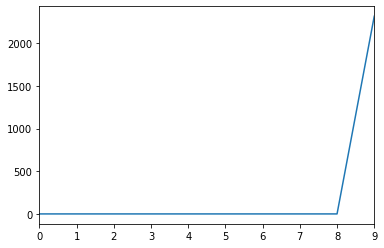

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2318]
-------------------------------------------
Time: 2020-03-14 03:07:40
-------------------------------------------
RT @marcushjohnson: Remaining primaries, including Tuesday’s in Illinois, will be diminished, but Joe Biden effectively has won the Democra…
...

-------------------------------------------
Time: 2020-03-14 03:07:40
-------------------------------------------
978

-------------------------------------------
Time: 2020-03-14 03:07:40
-------------------------------------------
('rt', 791)
('trump', 614)
('https', 239)
('coronavirus', 199)
('president', 146)
('pandemic', 87)
('donald', 76)
('white', 72)
('house', 61)
('national', 59)
...



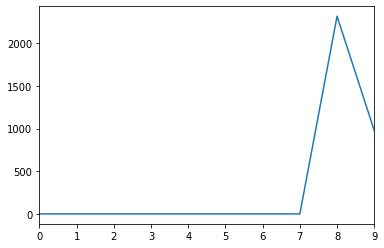

[0, 0, 0, 0, 0, 0, 0, 0, 2318, 978]
-------------------------------------------
Time: 2020-03-14 03:07:50
-------------------------------------------

...

-------------------------------------------
Time: 2020-03-14 03:07:50
-------------------------------------------
511

-------------------------------------------
Time: 2020-03-14 03:07:50
-------------------------------------------
('rt', 408)
('trump', 321)
('https', 126)
('coronavirus', 93)
('president', 75)
('white', 41)
('realdonaldtrump', 37)
('donald', 36)
('pandemic', 36)
('team', 33)
...



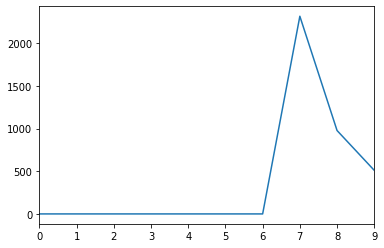

[0, 0, 0, 0, 0, 0, 0, 2318, 978, 511]
-------------------------------------------
Time: 2020-03-14 03:08:00
-------------------------------------------
Posiblemente trump de positivo por coronavirus
...

-------------------------------------------
Time: 2020-03-14 03:08:00
-------------------------------------------
502

-------------------------------------------
Time: 2020-03-14 03:08:00
-------------------------------------------
('rt', 402)
('trump', 328)
('https', 111)
('coronavirus', 96)
('president', 72)
('pandemic', 48)
('nt', 40)
('us', 38)
('donald', 38)
('white', 38)
...



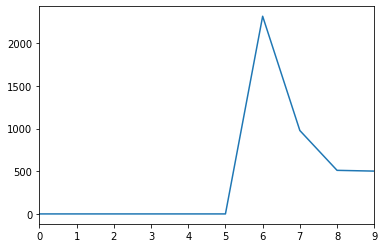

[0, 0, 0, 0, 0, 0, 2318, 978, 511, 502]
-------------------------------------------
Time: 2020-03-14 03:08:10
-------------------------------------------
RT @EdwardTHardy: 14 day ago, Donald Trump called coronavirus a hoax at a campaign rally
...

-------------------------------------------
Time: 2020-03-14 03:08:10
-------------------------------------------
506

-------------------------------------------
Time: 2020-03-14 03:08:10
-------------------------------------------
('rt', 415)
('trump', 313)
('https', 115)
('coronavirus', 79)
('president', 68)
('donald', 41)
('pandemic', 38)
('team', 37)
('us', 33)
('response', 32)
...



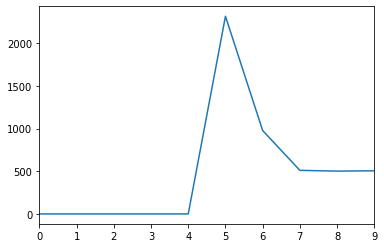

[0, 0, 0, 0, 0, 2318, 978, 511, 502, 506]
-------------------------------------------
Time: 2020-03-14 03:08:20
-------------------------------------------
Google Contradicts Trump: Coronavirus Site in 'Early Stages' #Topbuzz https://t.co/rZBBo0XFKn
...

-------------------------------------------
Time: 2020-03-14 03:08:20
-------------------------------------------
506

-------------------------------------------
Time: 2020-03-14 03:08:20
-------------------------------------------
('rt', 391)
('trump', 315)
('https', 121)
('coronavirus', 95)
('president', 60)
('pandemic', 45)
('white', 41)
('house', 36)
('donald', 36)
('team', 35)
...



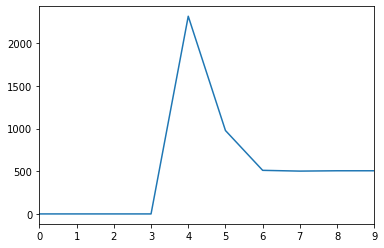

[0, 0, 0, 0, 2318, 978, 511, 502, 506, 506]
-------------------------------------------
Time: 2020-03-14 03:08:30
-------------------------------------------
RT @ajamubaraka: We are seeing in dramatic form the prioritization of ideology over health of population. Trump wants private sector in cha…
...

-------------------------------------------
Time: 2020-03-14 03:08:30
-------------------------------------------
502

-------------------------------------------
Time: 2020-03-14 03:08:30
-------------------------------------------
('rt', 403)
('trump', 301)
('https', 113)
('coronavirus', 89)
('president', 70)
('white', 41)
('nt', 37)
('team', 36)
('realdonaldtrump', 35)
('house', 32)
...



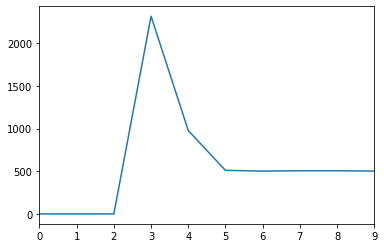

[0, 0, 0, 2318, 978, 511, 502, 506, 506, 502]
-------------------------------------------
Time: 2020-03-14 03:08:40
-------------------------------------------

...

-------------------------------------------
Time: 2020-03-14 03:08:40
-------------------------------------------
510

-------------------------------------------
Time: 2020-03-14 03:08:40
-------------------------------------------
('rt', 393)
('trump', 337)
('https', 109)
('coronavirus', 93)
('president', 58)
('donald', 42)
('realdonaldtrump', 33)
('white', 32)
('ago', 31)
('pandemic', 29)
...



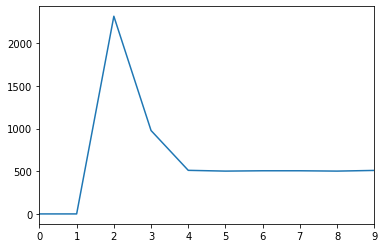

[0, 0, 2318, 978, 511, 502, 506, 506, 502, 510]
-------------------------------------------
Time: 2020-03-14 03:08:50
-------------------------------------------

...

-------------------------------------------
Time: 2020-03-14 03:08:50
-------------------------------------------
502

-------------------------------------------
Time: 2020-03-14 03:08:50
-------------------------------------------
('rt', 393)
('trump', 297)
('https', 130)
('coronavirus', 103)
('president', 61)
('pandemic', 47)
('white', 38)
('team', 37)
('nt', 36)
('realdonaldtrump', 35)
...



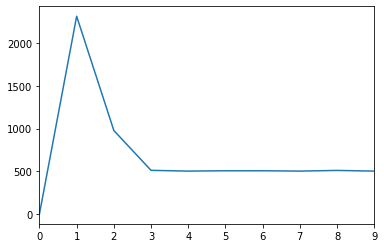

[0, 2318, 978, 511, 502, 506, 506, 502, 510, 502]
-------------------------------------------
Time: 2020-03-14 03:09:00
-------------------------------------------

...

-------------------------------------------
Time: 2020-03-14 03:09:00
-------------------------------------------
508

-------------------------------------------
Time: 2020-03-14 03:09:00
-------------------------------------------
('rt', 414)
('trump', 328)
('https', 116)
('coronavirus', 90)
('president', 59)
('white', 45)
('pandemic', 44)
('house', 40)
('realdonaldtrump', 39)
('donald', 37)
...



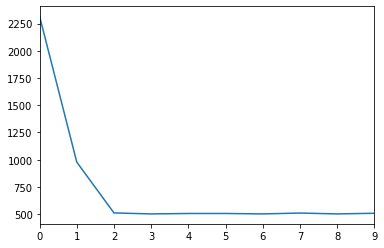

[2318, 978, 511, 502, 506, 506, 502, 510, 502, 508]
-------------------------------------------
Time: 2020-03-14 03:09:10
-------------------------------------------
Trending FOX BUSINESS News: Trump emerges as oil’s white knight after worst week since 2008 https://t.co/jrVTDOQadE https://t.co/SwbKL4KoMh
...

-------------------------------------------
Time: 2020-03-14 03:09:10
-------------------------------------------
509

-------------------------------------------
Time: 2020-03-14 03:09:10
-------------------------------------------
('rt', 414)
('trump', 316)
('https', 106)
('coronavirus', 83)
('white', 56)
('president', 56)
('team', 45)
('donald', 45)
('house', 39)
('pandemic', 38)
...



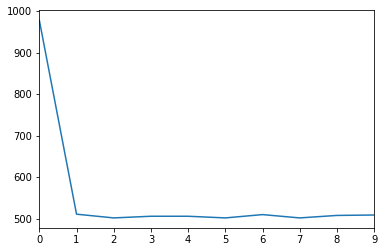

[978, 511, 502, 506, 506, 502, 510, 502, 508, 509]
-------------------------------------------
Time: 2020-03-14 03:09:20
-------------------------------------------
RT @ShannonSharpe: Ppl suffering and dying because millions elected an unqualified, tv personality. But his base and Republicans doesn’t ca…
...

-------------------------------------------
Time: 2020-03-14 03:09:20
-------------------------------------------
508

-------------------------------------------
Time: 2020-03-14 03:09:20
-------------------------------------------
('rt', 412)
('trump', 313)
('https', 123)
('coronavirus', 88)
('president', 62)
('pandemic', 42)
('team', 39)
('nt', 39)
('realdonaldtrump', 38)
('white', 36)
...



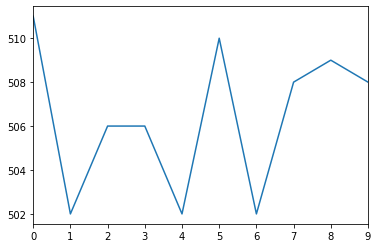

[511, 502, 506, 506, 502, 510, 502, 508, 509, 508]
-------------------------------------------
Time: 2020-03-14 03:09:30
-------------------------------------------
RT @Lrihendry: Dear God, tonight, I am praying for President Trump, his family, our leaders, hospital workers, doctors and nurses. Please k…
...

-------------------------------------------
Time: 2020-03-14 03:09:30
-------------------------------------------
512

-------------------------------------------
Time: 2020-03-14 03:09:30
-------------------------------------------
('rt', 415)
('trump', 324)
('https', 139)
('coronavirus', 95)
('president', 76)
('white', 51)
('realdonaldtrump', 39)
('today', 38)
('nt', 35)
('google', 34)
...



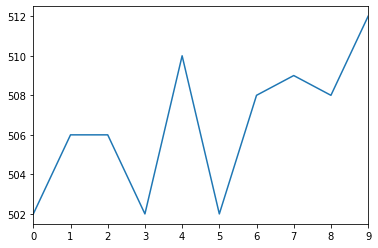

[502, 506, 506, 502, 510, 502, 508, 509, 508, 512]
-------------------------------------------
Time: 2020-03-14 03:09:40
-------------------------------------------
RT @HKrassenstein: BREAKING:  Trump has declared Sunday a "National Day of Prayer".

How about making it "National Coronavirus Testing Day"…
...

-------------------------------------------
Time: 2020-03-14 03:09:40
-------------------------------------------
505

-------------------------------------------
Time: 2020-03-14 03:09:40
-------------------------------------------
('rt', 402)
('trump', 310)
('https', 123)
('coronavirus', 85)
('president', 61)
('pandemic', 50)
('response', 38)
('team', 37)
('white', 37)
('donald', 37)
...



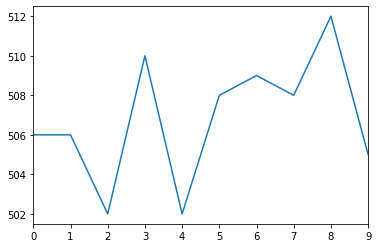

[506, 506, 502, 510, 502, 508, 509, 508, 512, 505]
-------------------------------------------
Time: 2020-03-14 03:09:50
-------------------------------------------
Donald Trump makes emergency decree; world ramps up fight against deadly virus https://t.co/8sFt8W21Dh https://t.co/tAoqqVofy9
...

-------------------------------------------
Time: 2020-03-14 03:09:50
-------------------------------------------
511

-------------------------------------------
Time: 2020-03-14 03:09:50
-------------------------------------------
('rt', 420)
('trump', 313)
('https', 105)
('coronavirus', 94)
('president', 63)
('donald', 41)
('white', 40)
('realdonaldtrump', 39)
('pandemic', 36)
('yamiche', 34)
...



KeyboardInterrupt: 

In [9]:
ssc.start()
ssc.awaitTermination()